# TP 2 : Computer Vision

## Part 3 : motion estimation

In this part of the TP, we are going to look at the following method for estimating motion :

- block matching

First, let us again load some packages and define some helper functions

(448, 624)

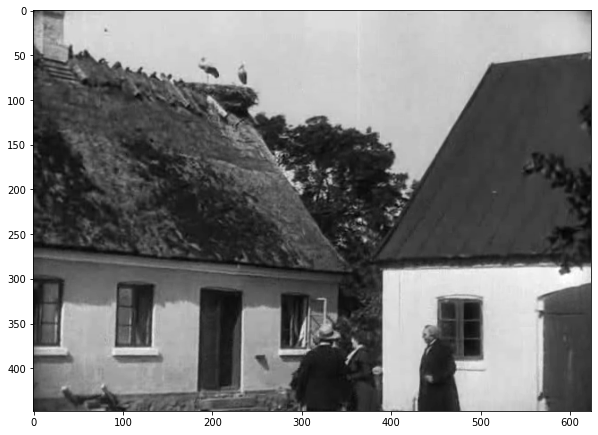

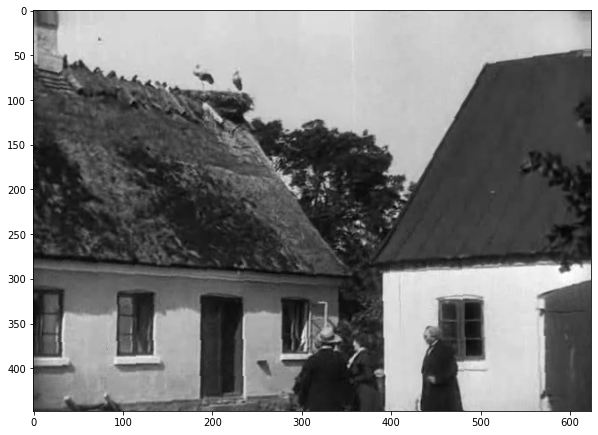

In [8]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np 
import imageio.v2 as imageio
from skimage import color
from scipy import signal
from scipy.ndimage.morphology import binary_dilation

is_colab = False

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

def display_motion(img_1,img_2,key_pts,motion,file_save=''):
    
    motion_x = motion[:,0]
    motion_y = motion[:,1]
    
    img_size = img_1.shape
    
    head_width=2.0
    head_length=3.0

    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    ax = plt.imshow(img_1,cmap='gray')

    print(key_pts.shape[0])
    for i in range(0,key_pts.shape[0]):
        x = key_pts[i,0]
        y = key_pts[i,1]
        plt.arrow(x,y, motion_x[i],motion_y[i] , color='r',
            head_width=head_width, head_length=head_length,)
    plt.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(mpl.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(mpl.ticker.NullLocator())

    if (file_save != ''):
        plt.savefig(file_save, bbox_inches = 'tight', pad_inches = 0)

file_dir = 'images/'
file_name_1 = 'afgrunden_1'
file_name_2 = 'afgrunden_2'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/afgrunden_1.png"
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/afgrunden_2.png"
  img_1,_ = read_image(file_name_1+file_ext)
  img_2,_ = read_image(file_name_2+file_ext)
else:
  img_1,_ = read_image(file_dir+file_name_1+file_ext)
  img_2,_ = read_image(file_dir+file_name_2+file_ext)

display_image(img_1)
display_image(img_2)
img_size = img_1.shape
img_size

In [9]:
img_1.shape[0]

448

__Question 3.1__ What sort of motion do you think is there between img_1 and img_2 ? You may want to flip between one image and another in an external viewer.

__Answer__ the image is been rotated.

## Block matching

Block matching is a very intuitive algorithm for motion estimation. We choose a patch size, and for each patch $\Psi_p$ in the first frame, we look for the patch $\Psi_q$ which is the most similar, in a certain region around the original position. The motion $(u,v)$ is then defined as $(u,v) = q-p$, such that : 

$
\begin{cases}
q_x = p_x+u\\
q_y = p_y+v
\end{cases}
$

The ''similarity'' between two patches is the sum of squared differences (SSD) :

$d(\Psi_p,\Psi_q) = \sum_{i \in \mathcal{N}} \left( I(p+i) - I(q+i) \right)^2,$

where $\mathcal{N}$ is the patch neighbourhood (a square).

We are going to be implementing block matching in a function called ``block_matching``. However, this can take a lot of time, so we only carry it out on a subset of the pixels, which we will call ``key_pts``. This will be a matrix of size $(N,2)$, where $N$ is the number of keypoints, and where each line has the following format :

- $[x,y]$

Create this function now, with the following parameters :

- block_size = 7 (the patch size)
- search_size = 15 (the maximum distance we search for the same patch in)

You will have to deal with border conditions. There are two ways of doing this :

- not allowing the patch search to go near to the borders (no closer than half the patch size)
- making partial patch comparisons

You can choose either method. The first is slightly easier to implement, but potentially incorrect near the borders. The second is more correct, but you have to make sure to make partial patch comparisons.

Make sure you do __not__ carry out the patch distance with a loop (which would not be very optimal). You can first create the patch neighbourhood with

- ``np.meshgrid``

and then take the SSD of the two patches.


In [10]:
from itertools import product

In [11]:
def block_matching(img_1,img_2,key_pts):
    neighbor_radius = 15
    block_radius = 3 # (7-1)//2
    img_shape = img_1.shape
    def search_neighbors(pt):
        # we only return a valid neighborhood, i.e. any points in it has a complete patch(no crop)
        x = range(max(block_radius,pt[0] - neighbor_radius), min(img_shape[1], pt[0] + neighbor_radius)+1, 1)
        y = range(max(block_radius,pt[1] - neighbor_radius), min(img_shape[0], pt[1] + neighbor_radius)+1, 1)
        return product(x,y)
    def patch(img, pt):
        # here we only return patch that in a valid neighborhood, so no more validity check
        # image indexing is reverse of the cartesian indexing
        return img[pt[1]-block_radius: pt[1]+block_radius+1: 1, pt[0]-block_radius: pt[0]+block_radius+1: 1]
    # return search_neighbors(key_pts[0])
    
    def SSD(patch1, patch2):
        return ((patch1 - patch2) ** 2).sum()
    
    
    # image of key points motion mapping
    key_pts_img = list()
    for src in key_pts[:,]:
        best_tar = None
        best_score = float('inf')
        neighborhood = search_neighbors(src)
        if neighborhood: # if neighborhood is not empty
            src_patch = patch(img_1, src)
            # print(src_patch.shape)
            # print(src)
            for tar in neighborhood:
                tar_patch = patch(img_2, tar)
                if src_patch.shape == tar_patch.shape:
                    score = SSD(src_patch, tar_patch) 
                    if score < best_score:
                        best_score = score
                        best_tar = tar
        if not best_tar: # if no best tar, no motion by default
            best_tar = src
        key_pts_img.append(best_tar)
    key_pts_img = np.asarray(key_pts_img)
    # print(key_pts)
    # print(key_pts_img)
    motion = key_pts_img - key_pts # ``motion'' SHOULD BE A MATRIX OF SIZE [n_pts,2]
    # motion_adapt = list()
    # # adapt from x,y to i,j
    # for vct in motion:
    #     motion_adapt.append([vct[1],vct[0]])
    # motion_adapt = np.array(motion_adapt)
    # return motion_adapt
    return motion

We now draw some random keypoints.

In [12]:
n_pts = 80
# a random seed, if you want repeatability
np.random.seed(10)

pixel_list = np.asarray(range(0,img_size[0]*img_size[1]))
np.random.shuffle(pixel_list)
key_pts = np.zeros((n_pts,2)).astype(int)
key_pts[:,1],key_pts[:,0] = np.unravel_index(pixel_list[0:n_pts],img_size)
# key_pts[:,0],key_pts[:,1] = np.unravel_index(pixel_list[0:n_pts],img_size)

Carry out the block matching and display the result with the ``display_motion`` function.

In [13]:
motion = block_matching(img_1, img_2, key_pts) # FILL IN HERE

80


<Figure size 432x288 with 0 Axes>

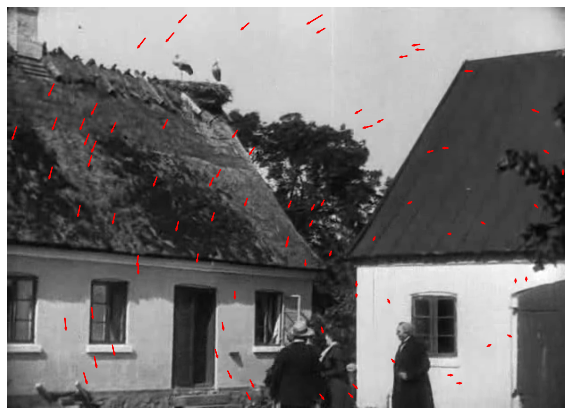

In [15]:
display_motion(img_1,img_2, key_pts ,motion)

__Question 3.2__ Does this look reasonable to you ? In what regions do you think the estimation might fail ? Does this visualisation confirm your hypothesis concerning the type of motion ?

__Answer__ Yes, it's quite reasonable where we find the vector field has a rotation pattern. The estimation fails around the right house since the color of roof and walls are somehow homogenous(i.e. less contrast) hence easy to mismatch the target key points.

__Question 3.3__ In this exercise, we used random points. What methods seen in the lesson could you use to choose better points. Explain why such points are better suited for the block matching algorithm.

__Answer__ we can first detect feature points and use them as key points. This is because for feature points(e.g. corners), the contrast of their neighborhood is more significant and easier to find the transformed key point.

In [16]:
from scipy.signal import convolve2d

In [17]:
from scipy.ndimage import maximum_filter

In [18]:
def harris_feature(img,k,alpha):
    patch_size = 7
    # gradients
    grad_x = np.gradient(img, axis=0)
    grad_y = np.gradient(img, axis=1)
    grad_x2 = grad_x * grad_x
    grad_y2 = grad_y * grad_y
    grad_xy = grad_x * grad_y
    f = np.ones((patch_size,patch_size)) # the kernel
    ix2 = convolve2d(grad_x2, f, mode='same')
    iy2 = convolve2d(grad_y2, f, mode='same')
    ixiy = convolve2d(grad_xy, f, mode='same')
    # A = np.zeros((2,2))
    img_harris_detect = np.zeros_like(img)
    # for ind_x, ind_y in np.ndindex(img.shape):
    #     A[0,0] = conv_grad_x2[ind_x,ind_y]
    #     A[1,0] = conv_grad_xy[ind_x,ind_y]
    #     A[0,1] = conv_grad_xy[ind_x,ind_y]
    #     A[1,1] = conv_grad_y2[ind_x,ind_y]
        # if abs(np.linalg.det(A) - alpha*np.trace(A)**2) > k:
        #     img_harris_detect[ind_x,ind_y] = 1
    harris_val = np.abs(ix2*iy2 - ixiy**2 - alpha*(ix2+iy2)**2)
    
    img_harris_detect = (maximum_filter(harris_val, patch_size) == harris_val) * (harris_val > k)
    return img_harris_detect

In [19]:
from itertools import product

In [20]:
def equalize_histogram(img_in: np.array):
    #INSERT CODE HERE
    hist_vals, hist_bins = np.histogram(img_in.flatten(), bins=np.linspace(0,1,257))
    H = np.cumsum(hist_vals).astype(float)
    # print(H.shape)
    H -= H.min()
    H /= H.max()
    # img_equalise = np.array([[H[int(img_in[i][j]*255)] for j in range(img_in.shape[1])] for i in range(img_in.shape[0])])

    indices = np.round(img_in * (H.shape[0]-1)).astype(int)
    img_equalise = img_in.copy()
    for (i,j) in product(range(img_in.shape[0]) , range(img_in.shape[1])):
        img_equalise[i,j] = H[indices[i,j]]
    return img_equalise
def annotate_image(img_in, img_harris):
    
    img_harris_out = np.tile( np.expand_dims(img_in,axis=2), (1,1,3))
    block_size = 5
    struct_el = np.ones((block_size,block_size))
    # now annotate the image
    img_harris = binary_dilation(img_harris,struct_el)
    img_harris_out[img_harris>0,0] = 1.0
    img_harris_out[img_harris>0,1:3] = 0.0
    
        
    return img_harris_out

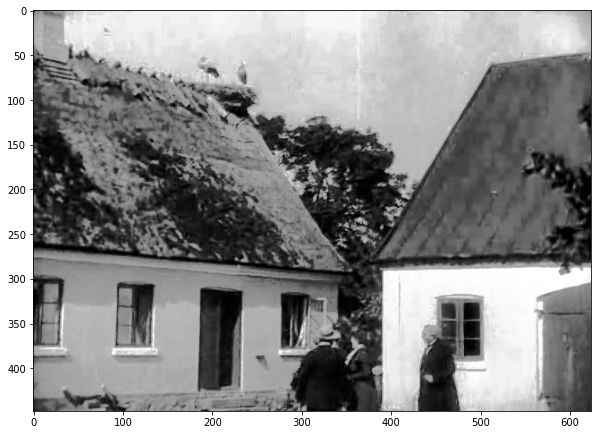

In [21]:
img_1_equalise = equalize_histogram(img_1)
display_image(img_1_equalise)

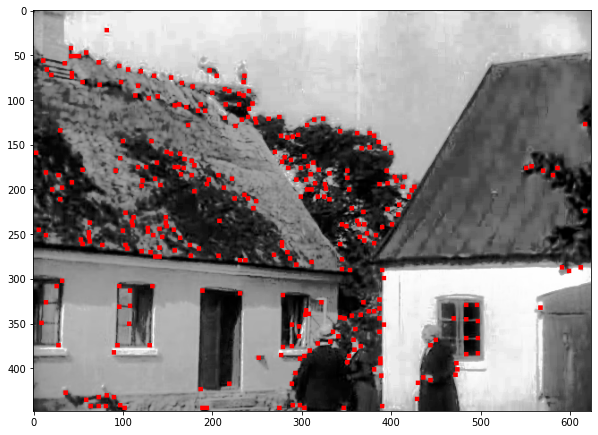

In [22]:
alpha = 0.04
k = 0.048
img_1_harris_equalise = harris_feature(img_1_equalise,k,alpha)
display_image(255.0*annotate_image(img_1_equalise,img_1_harris_equalise))

In [27]:
corner_pts = np.array(list(zip(*img_1_harris_equalise.nonzero())))

In [31]:
corner_pts_adapt = corner_pts.copy()
corner_pts_adapt[:,0] = corner_pts[:,1]
corner_pts_adapt[:,1] = corner_pts[:,0]

In [32]:
motion = block_matching(img_1, img_2, corner_pts_adapt)

327


<Figure size 432x288 with 0 Axes>

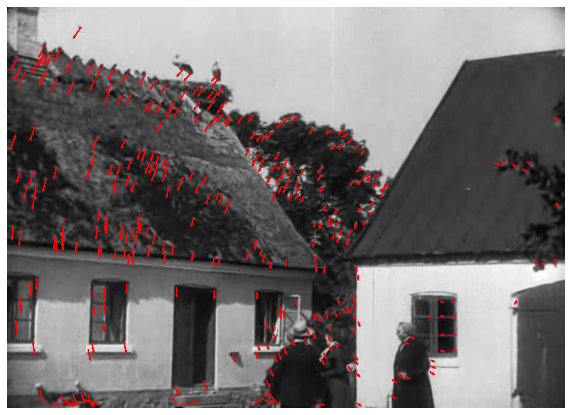

In [34]:
display_motion(img_1,img_2, corner_pts_adapt ,motion)

We find that there are no sufficient feature points on the right house.

__Question 3.4__ In this work, we have considered that each pixel/patch has its own, separate, local, motion. This is not the best model for the motion observed in these two images.

What is a better motion model to use here? Why is this model better? Describe an algorithm to calculate such a motion.

__Answer__ since by flipping between the two images, we can observe a global rotation. So it's better to use the affine motion model, which turns out to be solving a least squares problem.